In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
import re
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.text import Tokenizer


c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
therapis_responses = pd.read_csv("data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("data/Annotated_data.csv",delimiter=",")
annotated_data_copy = pd.merge(therapis_responses,annotated_data,on='Id_Number')
annotated_data_copy = annotated_data_copy.drop(['Question'],axis=1)

In [3]:
def label_distorsion_binary(row):
    if row["Dominant Distortion"] == "No Distortion":
        return 0
    return 1

annotated_data_copy["Distortion"] = annotated_data_copy.apply(label_distorsion_binary, axis=1)

In [4]:
data_list = annotated_data_copy.values.tolist()
# 0 = ANSWER   ,   1 = ID   ,   2 = QUESTION   ,   3 = DISTORTED PART   ,
# 4 = DOMINANT DISTORTION   ,   5 = SECONDARY DISTORTION   ,   6 = DISTORTION 1/0
data_list[0]

['Thank you for writing. You did nothing wrong! You did not put this woman in prison. She did it to herself. She befriended, manipulated and abused a vulnerable 14-year-old (actually, two young teens). She is a sexual offender who was grooming you, not loving you. She belongs in jail.This was never an equal or appropriate relationship. As a teacher, she used her position of authority and the fact you were needy and looked up to her as means to draw you in. She was so good at gaslighting you that you believed and still believe that her abuse was love. She did all the classic moves of an abuser: She gained control of you by making you think you were special. She isolated you, making you more and more dependent on her. She created a relationship where you were always on eggshells, trying not to say or do anything that would cause a fight. She created fights anyway and then made you feel like you were at fault. Apologies and presents followed — which only confused you more. Any time that y

In [5]:
questions = [el[2] for el in data_list]
distortions = [el[6] for el in data_list]

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
#sbert_model = SentenceTransformer('all-mpnet-base-v2')

questions_embeded = sbert_model.encode(questions)

X_train, X_test, y_train, y_test = train_test_split(questions_embeded, distortions, test_size=0.2)

c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense


METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model = Sequential() 
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)

input_shape = X_train.shape
model.build(input_shape)

model.summary()

hist = model.fit(X_train,np.array(y_train),validation_data=(X_test,np.array(y_test)),epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (2024, 16)                12304     
                                                                 
 dropout (Dropout)           (2024, 16)                0         
                                                                 
 dense_1 (Dense)             (2024, 16)                272       
                                                                 
 dropout_1 (Dropout)         (2024, 16)                0         
                                                                 
 dense_2 (Dense)             (2024, 1)                 17        
                                                                 
Total params: 12,593
Trainable params: 12,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
64/64 [==============================] - 

In [7]:
def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
 
	if validation == True:
		val_to_plot = [model.history["val_"+el] for el in labels]
  
	to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

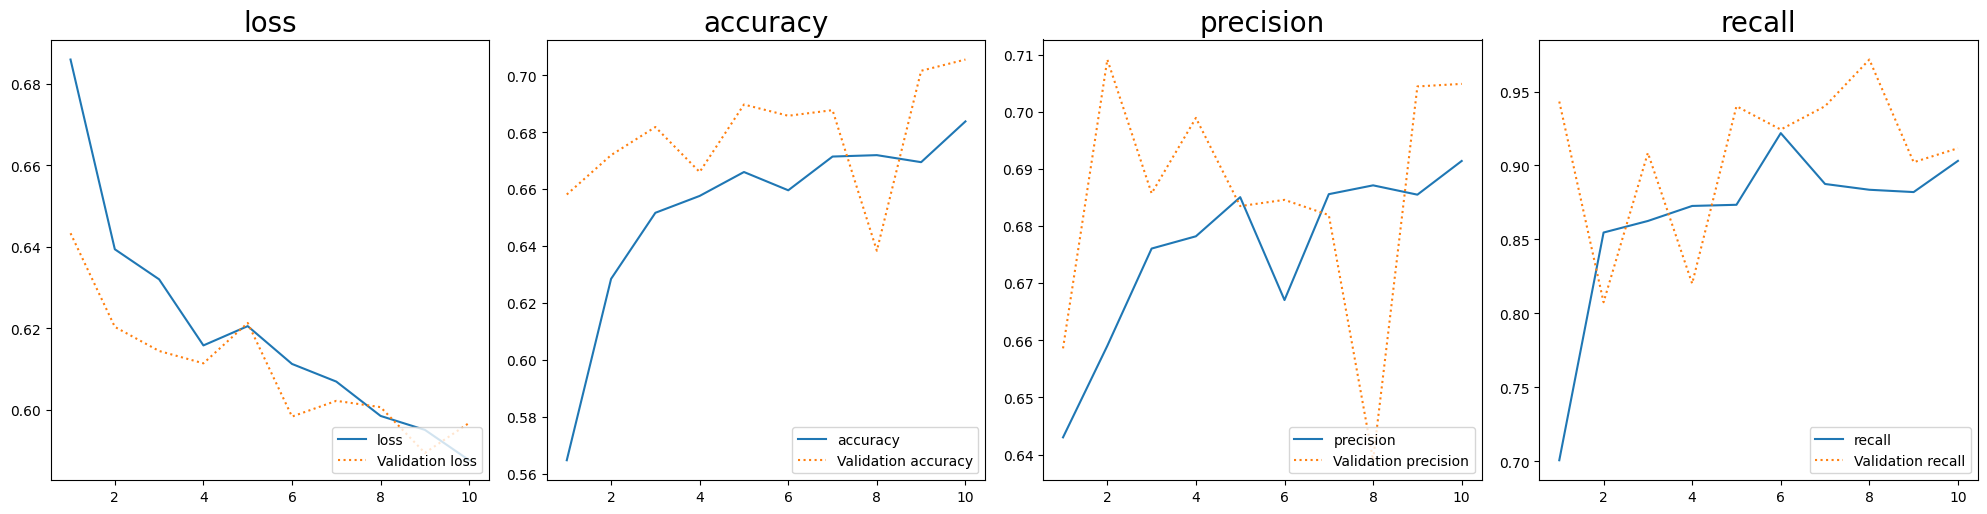

In [8]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],True)

16/16 [==============================] - 0s 6ms/step
acc:  0.7055335968379447
f1:  [0.47719298 0.79504814]


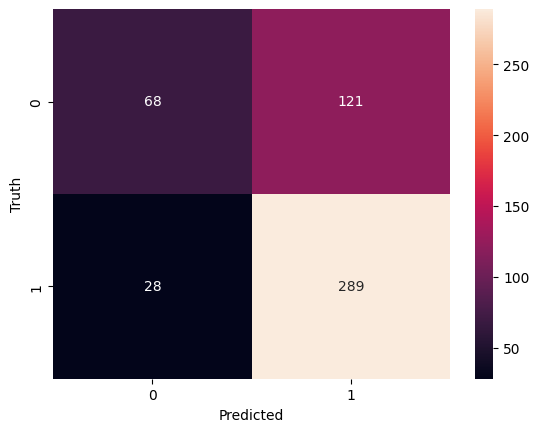

In [9]:
predicted = model.predict(X_test)
predicted = [1 if el>0.5 else 0 for el in predicted]

print("acc: ", accuracy_score(y_test, predicted))
print("f1: ",f1_score(y_test, predicted,average=None))

cm = confusion_matrix(y_test,predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.66600790513834


c:\Users\RoscaMitrut\.conda\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
